In [12]:

# %% Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read 
from IPython.display import Audio
from numpy.fft import fft, ifft
import pandas as pd
from scipy.fftpack import dct
import librosa
import librosa.display


In [13]:
metaData = pd.read_csv('../data/UrbanSound8K/metadata/UrbanSound8K.csv')
classes = list(metaData['class'].unique()) 


In [14]:

# Function to plot the waveform (stereo)
def plt_orig_waveform(sampleRate, soundData, channels):
    if channels == 'mono':
        soundData = soundData[:,0]
    clipLength = soundData.shape[0] / sampleRate
    time = np.linspace(0, clipLength, soundData.shape[0])
    plt.plot(time, soundData[:, 0], label="Left channel")
    plt.plot(time, soundData[:, 1], label="Right channel")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()
    print(f'Sample rate = {sampleRate}')
    print(f'Data points = {soundData.shape[0]}')
    print(f'Number of channels = {soundData.shape[1]}')
    print(f'Length = {clipLength}s')


In [15]:
files = dict()
for i in range(len(classes)):
    tmp = metaData[metaData['class'] == classes[i]][:1].reset_index()
    path = (
            '../data/UrbanSound8K/audio/fold{}/{}'
            .format(tmp['fold'][0], tmp['slice_file_name'][0])
            )
    files[classes[i]] = path



../data/UrbanSound8K/audio/fold5/100032-3-0-0.wav

../data/UrbanSound8K/audio/fold5/100263-2-0-117.wav

../data/UrbanSound8K/audio/fold10/100648-1-0-0.wav

../data/UrbanSound8K/audio/fold5/100852-0-0-0.wav

../data/UrbanSound8K/audio/fold7/101848-9-0-0.wav

../data/UrbanSound8K/audio/fold1/102305-6-0-0.wav


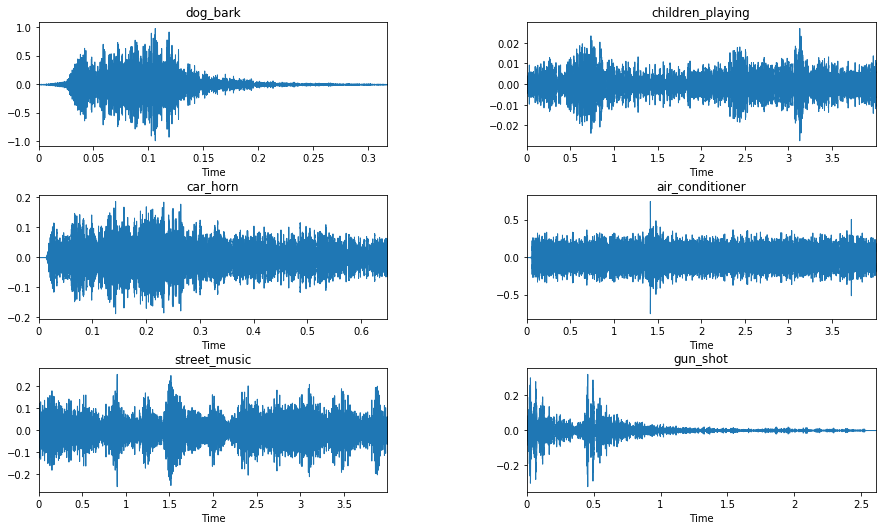

In [16]:
fig = plt.figure(figsize=(15,15))# Log graphic of waveforms to Comet
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(classes):
    if i < 6:
        fn = files[label]
        fig.add_subplot(5, 2, i+1)
        plt.title(label)
        print('\n' + fn)
        # sampleRate, soundData = read(fn) 
        soundData, sampleRate = librosa.load(fn)
        # plt_orig_waveform(sampleRate, soundData, 'stereo')
        librosa.display.waveplot(soundData, sr=sampleRate)


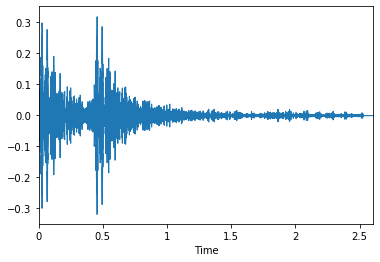

In [17]:
librosa.display.waveplot(soundData, sr=sampleRate)


In [18]:
Audio(soundData, rate=sampleRate) # IPython play audio widget


../data/UrbanSound8K/audio/fold1/102305-6-0-0.wav


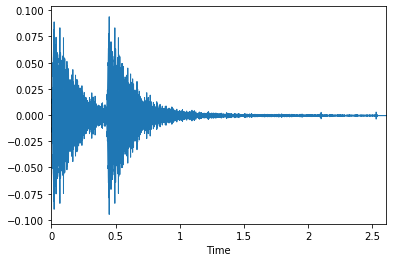

In [19]:
pre_emphasis = 0.97
emphasized_signal = np.append(soundData[0], soundData[1:] - pre_emphasis * soundData[:-1])
print(fn)
librosa.display.waveplot(emphasized_signal, sr=sampleRate)


In [20]:
Audio(emphasized_signal, rate=sampleRate) # IPython play audio widget


In [21]:
frame_size = 0.025
frame_stride = 0.01

frame_length = frame_size * sampleRate  # Convert from seconds to samples
frame_step = frame_stride * sampleRate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]


In [22]:
frames *= np.hamming(frame_length)


In [23]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum


In [24]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sampleRate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sampleRate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB


In [25]:
num_ceps = 12
cep_lifter = 22

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift  #*


In [26]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
